# Classification: Instant Recognition with Caffe

In this example we'll classify an image with PDNN model

We'll compare CPU computation and the NCS acceliration later.

## 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import math
import cv2
from cv_bridge import CvBridge, CvBridgeError

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
# we'll add it here explicitly.
# we assume caffe is installed at ~/caffe
import sys
caffe_root = '~/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* check the model files

In [3]:
import os
if os.path.isfile('models/donkey_pdnn.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Cannot load pre-trained CaffeNet model... Please talk to your TA!'

CaffeNet found.


## 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_mode_cpu()

model_def = 'models/donkey_pdnn.prototxt'
model_weights = 'models/donkey_pdnn.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

In [5]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

## 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          101, 101)  # image size is 101x101

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

/home/arg/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


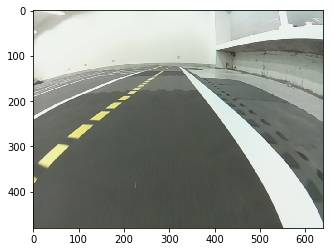

In [7]:
image = caffe.io.load_image('images/road_sample.jpg')
transformed_image = transformer.preprocess('data', image)
transformed_image = transformed_image - 128 # substract to 128
transformed_image = transformed_image * 0.0078125 # devided by (1/128) and normalize to -1 to 1

plt.imshow(image)

* This is a testing image in a Robotarium! Let's classify it!

In [8]:
%time
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
top1_class = output_prob.argmax()

### setting omega transform
steer_gain = 8.3 
omega = (top1_class *(2/14.) - 1) * steer_gain

### class 0 - 14
print 'predicted class is:', top1_class
print 'transform to omega:', omega

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs
predicted class is: 7
transform to omega: 0.0


## 4. Check if the prediction is correct or not

* Draw a vector pointing to the predicted direction on the image

320 384 320 284


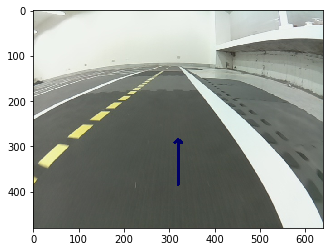

In [9]:
line_length = 100
height, width, channel = image.shape
bias = math.pi/2
direction = -(omega + bias)

x1 = int(round(width*0.5))
y1 = int(round(height*0.8))

x2 = int(round(x1 + line_length * math.cos(direction)))
y2 = int(round(y1 + line_length * math.sin(direction)))

print x1,y1,x2,y2
img_check = image
img_check = cv2.arrowedLine(img_check,(x1,y1),(x2,y2),(0,0,155),5)
plt.imshow(img_check)

## Discussion
* What's the time used in predict one picture? Compare to the time used with NCS
* Is it better to use NCS than caffe? What's you opinion

### Run below commands to see the output of all layers

In [10]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 101, 101)
conv1	(50, 32, 98, 98)
pool1	(50, 32, 49, 49)
conv2	(50, 32, 46, 46)
pool2	(50, 32, 23, 23)
conv3	(50, 32, 20, 20)
pool3	(50, 32, 10, 10)
conv4	(50, 32, 9, 9)
pool4	(50, 32, 5, 5)
fc1	(50, 200)
fc2	(50, 15)
prob	(50, 15)


## Discussion
* Why is the width and height of the output of conv1 is 98? Take a look at donkey_pdnn.prototxt in 07-ros-ncs/models folder

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [11]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(32, 3, 4, 4) (32,)
conv2	(32, 32, 4, 4) (32,)
conv3	(32, 32, 4, 4) (32,)
conv4	(32, 32, 4, 4) (32,)
fc1	(200, 800) (200,)
fc2	(15, 200) (15,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [12]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

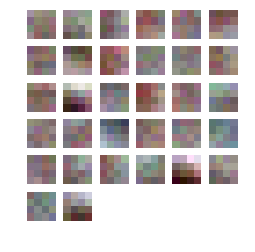

In [13]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

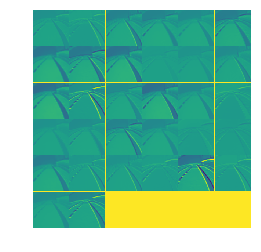

In [14]:
feat = net.blobs['conv1'].data[0, :]
vis_square(feat)

* The 4th layer after pooling, `pool4`

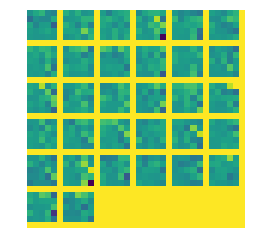

In [15]:
feat = net.blobs['pool4'].data[0]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

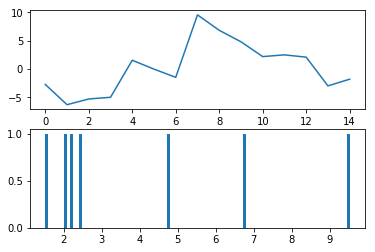

In [16]:
feat = net.blobs['fc2'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

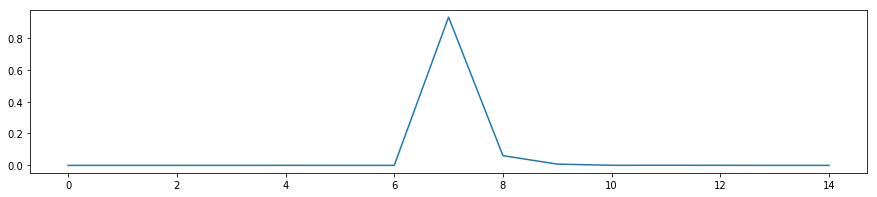

In [17]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

we put some image for testing in the folder images/
below are the name of all images you can use for testing


* images/road_0.jpg
* images/road_1.jpg
* images/road_2.jpg
* images/road_3.jpg
* images/road_4.jpg
* images/road_5.jpg
* images/road_6.jpg
* images/road_7.jpg
* images/road_8.jpg
* images/road_sample.jpg